In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [3]:
df = pd.read_csv('/kaggle/input/tayyor-edge-iiotset/Edge-IIoTset_99.csv', low_memory = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945449 entries, 0 to 1945448
Data columns (total 99 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   arp.opcode                 float64
 1   arp.hw.size                float64
 2   icmp.checksum              float64
 3   icmp.seq_le                float64
 4   icmp.transmit_timestamp    float64
 5   http.content_length        float64
 6   http.response              float64
 7   tcp.ack                    float64
 8   tcp.ack_raw                float64
 9   tcp.checksum               float64
 10  tcp.connection.fin         float64
 11  tcp.connection.rst         float64
 12  tcp.connection.syn         float64
 13  tcp.connection.synack      float64
 14  tcp.dstport                float64
 15  tcp.flags                  float64
 16  tcp.flags.ack              float64
 17  tcp.len                    float64
 18  tcp.seq                    float64
 19  udp.port                   float64
 20  ud

In [5]:
print(df['Attack_type'].value_counts())

Attack_type
Normal                   1399624
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36957
Backdoor                   24026
Port_Scanning              19977
XSS                        15068
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64


In [6]:
# Creating a dictionary of Types
attacks = {'Normal': 0,'MITM': 1, 'Uploading': 2, 'Ransomware': 3, 'SQL_injection': 4,
       'DDoS_HTTP': 5, 'DDoS_TCP': 6, 'Password': 7, 'Port_Scanning': 8,
       'Vulnerability_scanner': 9, 'Backdoor': 10, 'XSS': 11, 'Fingerprinting': 12,
       'DDoS_UDP': 13, 'DDoS_ICMP': 14}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [7]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_label']

In [8]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X, y)

In [9]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their scores
chi_scores = chi_scores.sort_values(by='score', ascending=False)

print(chi_scores)

         feature         score
8    tcp.ack_raw  1.460557e+14
7        tcp.ack  7.606459e+13
18       tcp.seq  7.310061e+12
20    udp.stream  4.093708e+11
22  dns.qry.name  4.196200e+10
..           ...           ...
89       mqtt1_8  1.169939e+00
84       mqtt1_3  7.799595e-01
90       mqtt1_9  7.799595e-01
91      mqtt1_10  7.799595e-01
85       mqtt1_4  7.799595e-01

[97 rows x 2 columns]


In [10]:
selected_features = chi_scores['feature'].tolist()[:93]  # Select top k features

In [11]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [12]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1361814, 93)
X_val shape: (194545, 93)
X_test shape: (389090, 93)


In [13]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 45, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 21, 64)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 21, 64)            33024     
                                                                 
 gru (GRU)                   (None, 64)                2

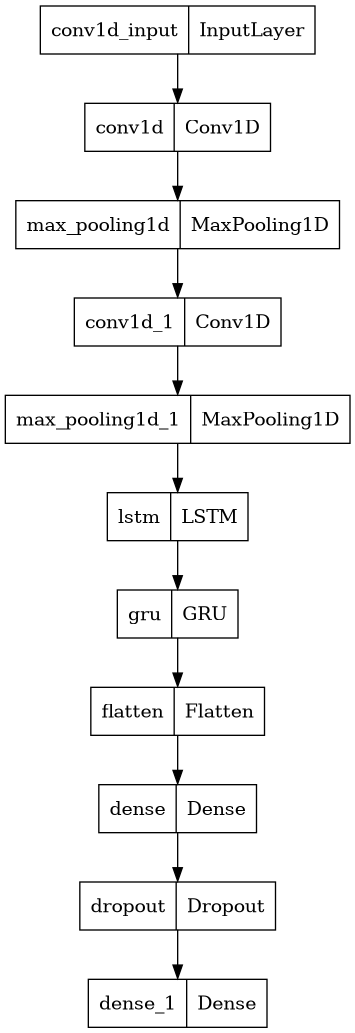

In [14]:
def cnn_lstm_gru_model(input_shape, num_classes):
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),        
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        LSTM(64, return_sequences=True),
        GRU(64, return_sequences=False),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], 1)
num_classes = 1
model = cnn_lstm_gru_model(input_shape, num_classes)
model.summary()
plot_model(model)

In [15]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=6, batch_size=32)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/6
42557/42557 [==============================] - 1302s 30ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 2.5022e-11 - val_accuracy: 1.0000
Epoch 2/6
42557/42557 [==============================] - 1291s 30ms/step - loss: 5.1622e-09 - accuracy: 1.0000 - val_loss: 6.2321e-18 - val_accuracy: 1.0000
Epoch 3/6
42557/42557 [==============================] - 1311s 31ms/step - loss: 3.3542e-11 - accuracy: 1.0000 - val_loss: 2.0223e-18 - val_accuracy: 1.0000
Epoch 4/6
42557/42557 [==============================] - 1275s 30ms/step - loss: 8.1462e-12 - accuracy: 1.0000 - val_loss: 6.5852e-19 - val_accuracy: 1.0000
Epoch 5/6
42557/42557 [==============================] - 1292s 30ms/step - loss: 1.2460e-11 - accuracy: 1.0000 - val_loss: 2.5857e-19 - val_accuracy: 1.0000
Epoch 6/6
12160/12160 [==============================] - 113s 9ms/step - loss: 7.1506e-19 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000
Training time: 7771.76 seconds
Testing time: 143.69 seconds


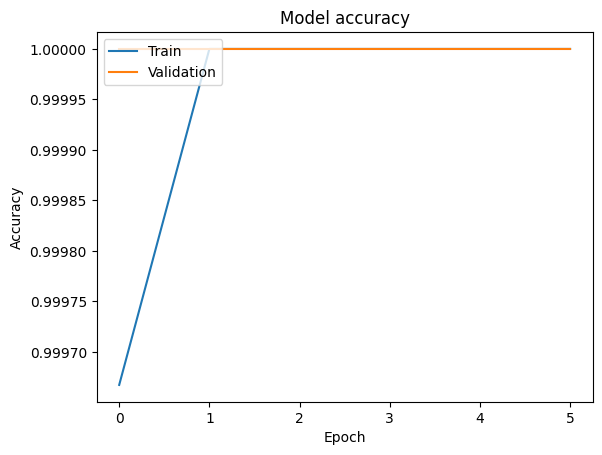

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

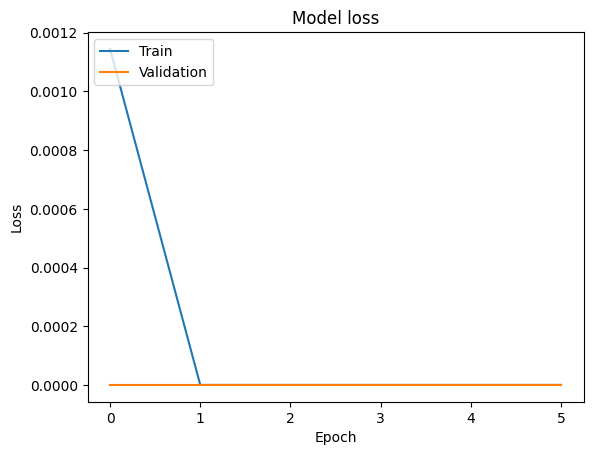

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [18]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

12160/12160 [==============================] - 111s 9ms/step


In [19]:
# Performance comparison table
print(classification_report(y_test, np.round(y_pred), target_names=['No Intrusion', 'Intrusion']))

              precision    recall  f1-score   support

No Intrusion       1.00      1.00      1.00    279968
   Intrusion       1.00      1.00      1.00    109122

    accuracy                           1.00    389090
   macro avg       1.00      1.00      1.00    389090
weighted avg       1.00      1.00      1.00    389090



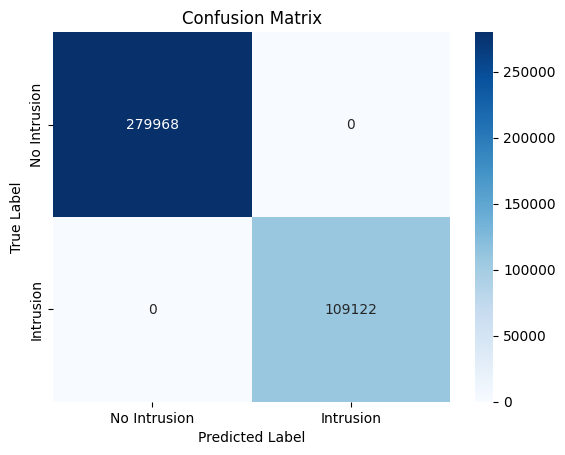

<Figure size 640x480 with 0 Axes>

In [20]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, np.round(y_pred))

# Define the class labels
class_labels = ['No Intrusion', 'Intrusion']

# Create a heatmap plot of the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set the plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
plt.savefig('con_max.jpg')

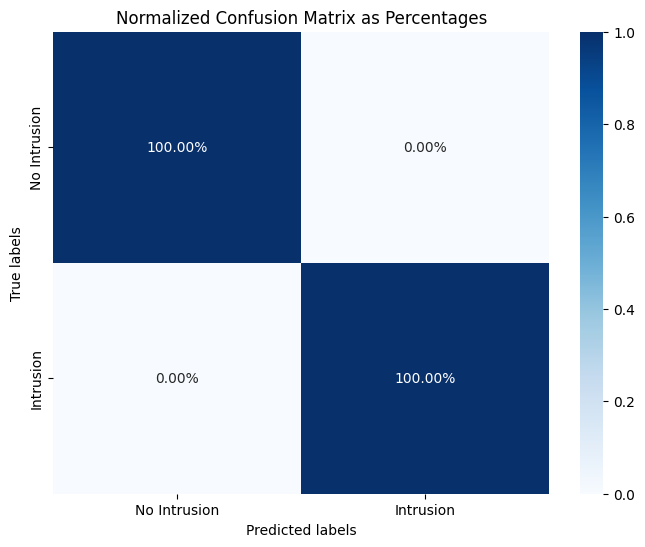

<Figure size 640x480 with 0 Axes>

In [21]:
# Predict the test set
y_pred = (y_pred > 0.5)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Define the class labels
class_labels = ['No Intrusion', 'Intrusion']
# Print confusion matrix as heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, fmt='.2%')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')